In [1]:
import math
import torch.nn as nn
import torchvision
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence

C:\Users\Will_\miniconda3\envs\csc413\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## **Step1 Load the data**

In [2]:
import dataloader
creature_imgs, creature_captions =dataloader.get_torch_creature_data() 

## **Step2 Process the data**
Turn both the image and captions in to embeddings,\
For images we are using **Alexnet** to obtain the features
For captions we are using Character by character **onehot** embeddings

* Character by character Onehot embedding

In [3]:
# use { and } as start of the sentence and end of sentence
# use @ as padding
def get_character_vocab(sentences):
    return list(set([i for sentence in sentences for word in sentence.lower() for i in word] ))+ ["{", "}"] + ["@"]
    

In [4]:
vocab = get_character_vocab(creature_captions)

In [5]:
vocab_stoi = {vocab[i] :i for i in range(len(vocab))}
vocab_itos = {i:vocab[i] for i in range(len(vocab))}    

In [6]:
def make_torch_token(sentences, vocab):
    tokens = []
    for sentence in sentences:
        token = [vocab_stoi["{"]] + [vocab_stoi[character] for character in sentence.lower()] + [vocab_stoi["}"]]
        tokens.append(token)
    return np.array(tokens)

In [7]:
def make_onehot(tokens,vocab):
    
    word_onehot = torch.eye(len(vocab))
    onehot_sentences = []
    for token in tokens:
        torch_onehot_sentence = word_onehot[token.int().tolist()]
        onehot_sentences.append(torch_onehot_sentence.unsqueeze(0))
    
    return onehot_sentences

In [8]:
def get_sentence_from_onehot(sentences, vocab):
    readable_sentences = []
    for sentence in sentences:
        readable_sentence = [vocab[torch.argmax(character)] for character in sentence]
    
        readable_sentences.append(readable_sentence)
         
    return readable_sentences

In [9]:
token_creature_captions = make_torch_token(creature_captions,vocab)

C:\Users\Will_\AppData\Local\Temp\ipykernel_12380\3107438979.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(tokens)


In [10]:
def get_padded_onehot_from_token(tokens):
    
    word_onehot = torch.eye(len(vocab))
    onehot_sentences=[]
    padded_tokens = pad_sequence(tokens,padding_value=vocab_stoi["@"],batch_first=True)
    for token in padded_tokens:
        
        torch_onehot_sentence = word_onehot[token.int().tolist()]
        onehot_sentences.append(torch_onehot_sentence.unsqueeze(0))
    return torch.cat(onehot_sentences)

    

* Alexnet

        Load Alexnet 

In [11]:
alexnet = torchvision.models.alexnet(pretrained=True)


In [12]:
class PositionalEncoding(nn.Module):
    def __init__(self,dropout_rate, input_dimensions,max_sequence_len, dimension2d=False):
        super(PositionalEncoding,self).__init__()
        self.dropout = nn.Dropout(p=dropout_rate)
        self.dimension2d = dimension2d
        positional_embedding = torch.zeros(input_dimensions,max_sequence_len)
        even = torch.arange(0,input_dimensions,2)
        odd = torch.arange(1,input_dimensions,2)
        position = torch.arange(max_sequence_len)
        denominator = torch.float_power(10000,even/input_dimensions)
        positional_embedding[0::2] = torch.sin(position.unsqueeze(0)/denominator.unsqueeze(1))
        positional_embedding[1::2] = torch.cos(position.unsqueeze(0)/denominator.unsqueeze(1))
        horizontal_positional_embedding = positional_embedding
        vertical_positional_embedding = positional_embedding
        if dimension2d:
            positional_embedding = horizontal_positional_embedding.unsqueeze(1) + vertical_positional_embedding.unsqueeze(2)
        else:
            positional_embedding = horizontal_positional_embedding.permute(1,0)
        self.register_buffer("positional_embedding",positional_embedding)
        
        
    def forward(self,x):
        if not self.dimension2d:
            
            x = x + self.positional_embedding[:x.shape[1],:].unsqueeze(0)
        else:

            x = x + self.positional_embedding[:,:x.shape[2],:x.shape[3]].unsqueeze(0)
        return self.dropout(x)       
        
        
        

In [13]:
class caption_transformer(nn.Module):
    def __init__(self,num_heads,hidden_size,dropout):
        super(caption_transformer,self).__init__()
        
        self.cnn_layer = nn.Conv2d(256,hidden_size,1)
        self.pool_layer = nn.MaxPool2d(2,2)
        
        self.fc_layer = nn.Linear(51,hidden_size)      
        self.transformer_layer = nn.Transformer(hidden_size,num_heads,batch_first=True,num_encoder_layers=2,num_decoder_layers=2)

        self.fc_layer2 = nn.Linear(hidden_size,hidden_size)
        self.fc_layer3 = nn.Linear(hidden_size,51)
        
        self.positional_embedding_source = PositionalEncoding(dropout, hidden_size,3,dimension2d=True)
        self.positional_embedding = PositionalEncoding(dropout,hidden_size,300)
        
    def forward(self, inp, target,mask=True):
        
        emb_inp = alexnet.features.cuda()(inp)
       
        
        # embed the image
        emb_inp = torch.relu(self.cnn_layer(emb_inp))
        emb_inp = self.pool_layer(emb_inp)
        
        # positional embedding for source
        
        emb_inp2 = self.positional_embedding_source(emb_inp)
 
        # embed the text
        emb_target = self.fc_layer(target)
        
        # positional embedding for target
        emb_target2 = self.positional_embedding(emb_target) 
                
        tgt_mask = self.make_tgt_mask(emb_target2).to(device) if mask else None
        
        emb_inp2 = emb_inp2.flatten(2).transpose(1,2)
        out = self.transformer_layer(emb_inp2,emb_target2,tgt_mask=tgt_mask)
        out1 = self.fc_layer2(out)
        out2 = self.fc_layer3(out1)
        
        return out2
        
    def make_tgt_mask(self,tgt):
        M, N, tgt_len = tgt.shape
        tgt_mask = torch.tril(torch.ones((N,N)) ==1)
        tgt_mask = tgt_mask.float()
        tgt_mask = tgt_mask.masked_fill(tgt_mask==0, float('-inf'))
        tgt_mask = tgt_mask.masked_fill(tgt_mask ==1, float(0.0)) 
        return tgt_mask
        
        

In [14]:
class My_Dataset(torch.utils.data.Dataset):
    def __init__(self, source, target):
        self.datasetA = source
        self.datasetB = target
    
    def __getitem__(self, index):
        xA = self.datasetA[index]
        xB = self.datasetB[index]
        return xA, xB
    
    def __len__(self):
        return len(self.datasetA)

In [15]:

def get_accuracy(model, data,batch_size = 10):
    model.eval()
    num = 0
    correct = 0
    mini_batch = torch.utils.data.DataLoader(data,batch_size = batch_size)
    for x,y in mini_batch:
        N, S, W = y.shape 
        num+=N*S
        out = model(x,y[:,:-1,:])
        correct += torch.sum(torch.argmax(out,2) == torch.argmax(y[:,1:,:],2))
    return correct/num

In [16]:

def train(model, train_data,valid_data, num_epoches=10, batch_size=30, \
                learning_rate = 0.1, weight_decay = 0,checkpoint_path = None):
    
    criterion = nn.CrossEntropyLoss().cuda()
    optimizer = optim.AdamW(model.parameters(),lr = learning_rate,weight_decay=weight_decay)
    #optimizer = optim.Adam(model.parameters(),lr = learning_rate, weight_decay=weight_decay)
    train_accs, val_accs  = [], [] 
    iters, losses = [], []
    n=0
    for epoch in range(num_epoches):
        mini_batch = torch.utils.data.DataLoader(train_data,batch_size = batch_size,shuffle = True)
        num_update = 0
        
        for x,t in mini_batch:  
            model.train()
            num_update += 1

            y = model(x,t[:,:-1,:])

            loss = criterion(y,t[:,1:,:])
     
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            
            
            n+=1
            
        iter = epoch
        
        train_cost = float(loss.cpu().detach().numpy())
        train_acc = get_accuracy(model, train_data)
        val_acc = get_accuracy(model, valid_data)
        print("Iter %d. [Val Acc %.0f%%] [Train Acc %.0f%%, Loss %f]" % (
                    iter, val_acc * 100, train_acc * 100, train_cost))
        #print("Iter %d.  [Train Loss %f]" % (
        #            iter,  train_cost))
        
        iters.append(iter)
        losses.append(loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        if (checkpoint_path is not None) and n > 0:
            torch.save(model.state_dict(), checkpoint_path.format(iter))

        
    plt.title("Training curve")
    plt.plot(iters, [i.cpu() for i in train_accs], label = "Train")
    plt.plot(iters, [i.cpu() for i in val_accs], label = "Valid")

    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    
    plt.figure()
    plt.title("Training loss")
    plt.plot(iters,[i.cpu().detach().numpy() for i in losses], label = "Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    

In [17]:
def generate_captions(source,model,stop_early= False):
    model.eval()
    start = torch.Tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]]]).to(device)
    end = torch.Tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]]]).to(device)

    temp = start
    for i in range(200):

        inter = model(source.unsqueeze(0).to(device),temp)
        combine = torch.cat((temp,inter[:,-1,:].unsqueeze(0)),dim=1)
        #temp = combine
        temp = emphesis(combine)
        if stop_early:
            if torch.argmax(temp[:,-1,:]) == torch.argmax(end):
                  break
    readable = get_sentence_from_onehot(temp,vocab)
    return readable

In [18]:
def describe(n, model,stop_early = False):
    '''describe the image given only the start token'''
    feature = creature_imgs[n:n+1].to(device)
    model.eval()
    out = generate_captions(feature[0],model,stop_early)
    plt.imshow(creature_imgs[n].int().permute(1,2,0))
    print(''.join(out[0]))
   
    

In [19]:
def describe2(n,model):
    '''describe the image give the masked caption'''
    model.eval()
    feature = creature_imgs[n:n+1].to(device)
    target = get_padded_onehot_from_token([torch.Tensor(i) for i in token_creature_captions[n:n+1]]).to(device)
    out = model(feature,target[:,:-1,:])
    print(''.join(get_sentence_from_onehot(out,vocab)[0]))

In [20]:
def emphesis(onehot):
    temp = torch.argmax(onehot,dim = 2)
    return get_padded_onehot_from_token([i for i in temp]).to(device)

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

In [22]:
'''Get the suffled index'''
f = open("indexes.txt","r")
index = f.readlines()
index = [int(i[:-1]) for i in index]

In [23]:
valid_pic = creature_imgs[index[6500:7500]].to(device)
valid_caption = get_padded_onehot_from_token([torch.Tensor(i) for i in token_creature_captions[index[6500:7500]]]).to(device)
valid_dataset = My_Dataset(valid_pic,valid_caption)

In [24]:
train_pic = creature_imgs[index[:6500]].to(device)
train_caption = get_padded_onehot_from_token([torch.Tensor(i) for i in token_creature_captions[index[:6500]]]).to(device)
train_dataset = My_Dataset(train_pic, train_caption)

In [25]:
test_pic = creature_imgs[index[7500:]].to(device)
test_caption = get_padded_onehot_from_token([torch.Tensor(i) for i in token_creature_captions[index[7500:]]]).to(device)
test_dataset = My_Dataset(test_pic,test_caption)

In [26]:
cuda_final = caption_transformer(8,128,0.1).to(device)

In [27]:
train(cuda_final,train_dataset,valid_dataset,1000,batch_size=30,learning_rate=0.00005, checkpoint_path="./checkpoints/6500/6500-{}.pk")

Iter 0. [Val Acc 67%] [Train Acc 71%, Loss 15.622054]
Iter 1. [Val Acc 72%] [Train Acc 76%, Loss 15.205817]
Iter 2. [Val Acc 73%] [Train Acc 76%, Loss 15.116148]
Iter 3. [Val Acc 73%] [Train Acc 76%, Loss 15.126527]
Iter 4. [Val Acc 73%] [Train Acc 76%, Loss 14.766800]
Iter 5. [Val Acc 73%] [Train Acc 76%, Loss 14.982752]
Iter 6. [Val Acc 73%] [Train Acc 76%, Loss 14.782964]


KeyboardInterrupt: 

In [35]:
tiny_valid_features = creature_imgs[:5].to(device)
tiny_valid_captions = get_padded_onehot_from_token([torch.Tensor(i) for i in token_creature_captions[:5]]).to(device)
tiny_valid_data = My_Dataset(tiny_valid_features,tiny_valid_captions)

In [36]:
tiny_pic = creature_imgs[-100:].to(device)
tiny_captions = get_padded_onehot_from_token([torch.Tensor(i) for i in token_creature_captions[-100:]]).to(device)
tiny_train_data = My_Dataset(tiny_pic,tiny_captions)

In [81]:
cuda_tiny = caption_transformer(8,128,0.1).to(device)

Iter 0. [Val Acc 14%] [Train Acc 10%, Loss 8.905822]
Iter 1. [Val Acc 44%] [Train Acc 54%, Loss 8.465702]
Iter 2. [Val Acc 41%] [Train Acc 50%, Loss 8.461713]
Iter 3. [Val Acc 38%] [Train Acc 49%, Loss 8.485534]
Iter 4. [Val Acc 48%] [Train Acc 58%, Loss 8.061346]
Iter 5. [Val Acc 52%] [Train Acc 61%, Loss 7.880385]
Iter 6. [Val Acc 52%] [Train Acc 62%, Loss 7.810341]
Iter 7. [Val Acc 48%] [Train Acc 60%, Loss 7.794705]
Iter 8. [Val Acc 48%] [Train Acc 59%, Loss 7.687326]
Iter 9. [Val Acc 49%] [Train Acc 61%, Loss 7.527262]
Iter 10. [Val Acc 49%] [Train Acc 61%, Loss 7.687551]
Iter 11. [Val Acc 50%] [Train Acc 61%, Loss 7.493530]
Iter 12. [Val Acc 48%] [Train Acc 60%, Loss 7.415035]
Iter 13. [Val Acc 49%] [Train Acc 61%, Loss 7.373868]
Iter 14. [Val Acc 51%] [Train Acc 62%, Loss 7.557561]
Iter 15. [Val Acc 51%] [Train Acc 62%, Loss 7.434743]
Iter 16. [Val Acc 51%] [Train Acc 61%, Loss 7.348909]
Iter 17. [Val Acc 49%] [Train Acc 60%, Loss 7.597012]
Iter 18. [Val Acc 50%] [Train Acc 61%,

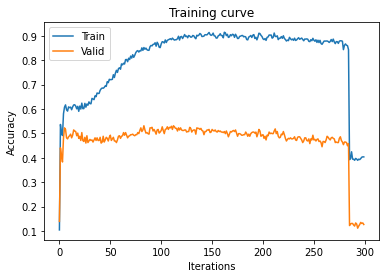

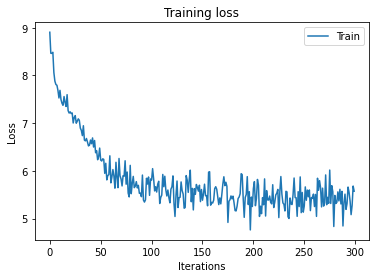

In [82]:
train(cuda_tiny,tiny_train_data,tiny_valid_data,300,batch_size= 10,learning_rate=0.001, checkpoint_path="./checkpoints/tiny/tiny-{}.pk")

{a-brown--dog and a black-'sing ov-thell }@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
a-brown-dog and a black-jog-run-into each-other-}n-phe grasss}
A brown dog and a black dog run into each other in the grass 


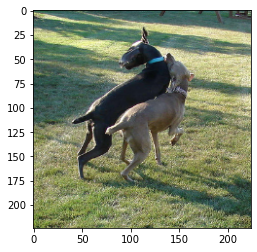

In [107]:
n=-39
describe(n,cuda_final)
describe2(n,cuda_final)
print(creature_captions[n])

tensor(0.6304, device='cuda:0')
{2nw2pppwbp2p2m3w'.222sijtp,)yi1pnp7sijpppi7spp}@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
24442w2pgpp,,p,4,i,jp,,,ppps,p1,,,,p,pppj,
A brown dog plays in a deep pile of snow 


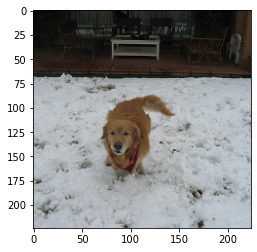

In [79]:
cuda_final.load_state_dict(torch.load('./checkpoints/6500/6500-690.pk'))
print(get_accuracy(cuda_final,valid_dataset))
n=80
describe(n,cuda_final)
describe2(n,cuda_final)
print(creature_captions[n])